# Visual Object Classes Challenge 2012 (VOC2012)

CopyRight by 黑板客

请勿转载，谢谢


### 1. 数据介绍

VOC2012是一个相当出名的计算机视觉竞赛数据，有2G带标注的图片数据用来训练模型。经常用来训练各种深度学习的模型。

该竞赛2005年开始，开始时只有分类任务，并且图片的类别只有4类。到2007年增加到20类，同时增加了图像分割，人体轮廓识别等任务。

20个类别都是常见物体。包括

    人类
    动物（鸟、猫、牛、狗、马、羊）
    交通工具（飞机、自行车、船、公共汽车、小轿车、摩托车、火车）
    室内（瓶子、椅子、餐桌、盆栽植物、沙发、电视）

这里有个中国的牛人在竞赛里获得不错的成绩。有兴趣可以看看：http://www.cbsr.ia.ac.cn/users/ynyu/

数据可以官网获得
http://host.robots.ox.ac.uk/pascal/VOC/voc2012/

也可以通过bd云，
链接: https://pan.baidu.com/s/1i4B5Kah 密码: 15qy

不过课程需要的比较大的数据都会公布在这里。请大家不要公开该分享，避免被清理，谢谢支持！

### 2. 数据使用


我们主要使用VOCtrainval_11-May-2012.tar文件，数据解压后有几个文件夹

    JPEGImages里是训练用的图片，图片尺寸不等。需要进行数据处理。
    Annotations中存放的是xml格式的标签文件，每一个xml文件都对应于JPEGImages文件夹中的一张图片
    ImageSets存放的是每一种类型的比赛对应的图像数据的List，我们用的是main下的物体识别的图片。
    SegmentationClass和SegmentationObject放的是物体分割用到的数据，这里先不做介绍了。
    
具体使用，我们会先读取ImageSets里的trainVal的list，然后将每一副图像处理成固定尺寸得到data，同时读取对应的xml文件获得类别的label。下面我们先举个一张图片的例子。

In [1]:
#coding='utf-8'

import scipy.misc
import caffe

import numpy as np
import os.path as osp

from xml.dom import minidom
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

% matplotlib inline

#导入必须的库，如果出错需要先行安装需要的库

In [2]:
# 利用开源代码读取VOC2012的标注数据
# index：图像文件名称，不带后缀
# pascal_root：VOC2012数据保存目录
# 返回的字典里['gt_classes']内保存的就是分类的标号，
# 具体类别可通过访问classes来获得

classes = ('__background__',  # always index 0
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
            'cow', 'diningtable', 'dog', 'horse',
            'motorbike', 'person', 'pottedplant',
            'sheep', 'sofa', 'train', 'tvmonitor')

def load_pascal_annotation(index, pascal_root):
    """
    This code is borrowed from Ross Girshick's FAST-RCNN code
    (https://github.com/rbgirshick/fast-rcnn).
    It parses the PASCAL .xml metadata files.
    See publication for further details: (http://arxiv.org/abs/1504.08083).

    Thanks Ross!

    """

    class_to_ind = dict(zip(classes, xrange(21)))

    filename = osp.join(pascal_root, 'Annotations', index + '.xml')
    # print 'Loading: {}'.format(filename)

    def get_data_from_tag(node, tag):
        return node.getElementsByTagName(tag)[0].childNodes[0].data

    with open(filename) as f:
        data = minidom.parseString(f.read())

    objs = data.getElementsByTagName('object')
    num_objs = len(objs)

    boxes = np.zeros((num_objs, 4), dtype=np.uint16)
    gt_classes = np.zeros((num_objs), dtype=np.int32)
    overlaps = np.zeros((num_objs, 21), dtype=np.float32)

    # Load object bounding boxes into a data frame.
    for ix, obj in enumerate(objs):
        # Make pixel indexes 0-based
        x1 = float(get_data_from_tag(obj, 'xmin')) - 1
        y1 = float(get_data_from_tag(obj, 'ymin')) - 1
        x2 = float(get_data_from_tag(obj, 'xmax')) - 1
        y2 = float(get_data_from_tag(obj, 'ymax')) - 1
        cls = class_to_ind[
            str(get_data_from_tag(obj, "name")).lower().strip()]
        boxes[ix, :] = [x1, y1, x2, y2]
        gt_classes[ix] = cls
        overlaps[ix, cls] = 1.0

    overlaps = scipy.sparse.csr_matrix(overlaps)

    return {'boxes': boxes,
            'gt_classes': gt_classes,
            'gt_overlaps': overlaps,
            'flipped': False,
            'index': index}


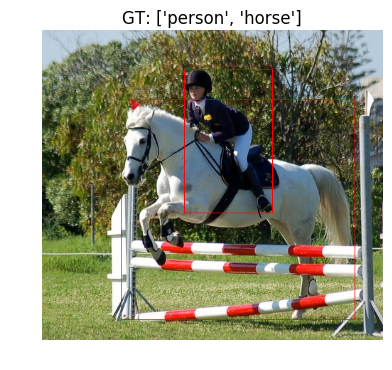

In [4]:
#该目录需要根据自己解压后的数据目录进行修改
pascal_root = '/home/hbk/Documents/bigData/VOC2012/'

filename = '2007_000783' #000783

plt.figure()
img = Image.open(pascal_root+'JPEGImages/'+filename+'.jpg')
gt = load_pascal_annotation(filename, pascal_root)
draw = ImageDraw.Draw(img)

for box in gt['boxes']:
    draw.rectangle(list(box), outline = 'red')

plt.imshow(img)
plt.title('GT: {}'.format([classes[g] for g in gt['gt_classes']]))
plt.axis('off');

# 我们把类别显示在标题上， GT代表Groud Truth
# box代表这个物体在哪个区域，我们用红色框表示。

### 3. Caffe使用VOC2012

因此，我们可以根据以下几步来生成Caffe所需的数据，并且验证。

1. 读取VOC2012/ImageSets/Main/train.txt得到训练图片列表，val.txt得到验证图片列表。
2. 依次调用load_pascal_annotation函数可以得到每张图片的类别
3. 用multilabel的方式，将调整大小后的图片作为data，将类别作为label。存储为hdf5格式。
4. 用简单的神经网络进行训练实验。


In [4]:
# 举个例子，比如我们读取图像列表trainval.txt

list_file = 'trainval.txt'
indexlist = [line.rstrip('\n') for line in open(
        osp.join(pascal_root, 'ImageSets/Main', list_file))]

# 然后输出前10个图像的label
for i, name in enumerate(indexlist[0:10]):
    multilabel = np.zeros(20).astype(np.float32)
    img = Image.open(pascal_root+'JPEGImages/'+name+'.jpg')
    img = scipy.misc.imresize(img, (227,227)).transpose((2,0,1))
    anns = load_pascal_annotation(name, pascal_root)
    for label in anns['gt_classes']:
        multilabel[label - 1] = 1
    print multilabel

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  1.  0.]
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.
  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.]
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  1.]


剩余部分作为作业留给大家自己完成。完成后别忘了到讨论区分享哦，最后友情提示一下，学到这里，硬盘空间或者内存太小的需要考虑升级了。：）